**Experimental!** [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mthoren-adi/ROUS/blob/master/educational/ADC_crash_course/ADC_Crash_Course.ipynb)

# ADC Crash Course!

An attempt to aggregate a bunch of lessons learned items from several decades of ADC applications.

This notebook is intended to be accessible from several angles:
Running Jupyter Notebook locally
Running in Google Colab - no istallation of anything needed!

Either of these can run the simulation cells, and dependencies will be kept to a minimum.

There will also be examples that talk to hardware - this requires that the local runtime environment be set up properly with all dependencies. Notes are included below on how to connect to the local runtime from Google Colab as well.

Tested with Jupyter Notebook as installed with Anaconda. Install extensions by running:

**pip install jupyter_contrib_nbextensions**

**jupyter contrib nbextension install**

## Table of Contents:

**Still playing with formatting. ToC(2) extension looks better.**

* [Introduction](#intro)
* [Basics of Analog to Digital conversion: Quantization](#quantization)
* [Basics of Signal Analysis using the FFT](#fft_basics)
* [Windowing](#windowing)
* [Tools for Deeper Analysis: Pscope](#pscope)
* [Tools for Deeper Analysis: Genalyzer](#genalyzer)
* [Thermal Noise (or, When "bits" Don't Matter)](#thermal_noise)
* [Adding Phase Noise and Distortion to the Signal Generator](#sig_gen_features)
* [Phase Noise](#phase_noise)
* [Distortion](#distortion)
* [Talking to Actual ADC Hardware](#hardware)


## References to organize later:

1. Maximum SNR vs. Clock Jitter:
https://www.analog.com/en/technical-articles/maximum-snr-vs-clock-jitter.html

2. Sampled Systems and the Effects of Clock Phase Noise and Jitter:
http://www.analog.com/AN-756

3. On the Use of Windows for Harmonic Analysis With the Discrete Fourier Transform, Frederic Harris
https://www.researchgate.net/publication/2995027_On_the_Use_of_Windows_for_Harmonic_Analysis_With_the_Discrete_Fourier_Transform
4. "Taking the Mystery "SNR = 6.02N + 1.76dB," and Why You Should Care" (EVEN THOUGH with most modern converters you shouldn't care 🙂 ) https://www.analog.com/media/en/training-seminars/tutorials/mt-001.pdf 

5. IEEE 1241-2010 - IEEE Standard for Terminology and Test Methods for Analog-to-Digital Converters: https://ieeexplore.ieee.org/document/5692956

6. MT-200: Minimizing Jitter in ADC Clock Interfaces:
https://www.analog.com/media/en/training-seminars/tutorials/MT-200.pdf

7. DN1013 - Understanding the Effect of Clock Jitter on High Speed ADCs:
https://www.analog.com/media/en/reference-design-documentation/design-notes/dn1013f.pdf

8. Scientist & Engineer's Guide to Digital Signal Processing, 1999:
https://www.analog.com/en/education/education-library/scientist_engineers_guide.html
(While still largely relevant, note that Chapter 3 on ADC and DAC dwells heavily on high-order analog filters, which have largely been replaced in oversampling converters.)

9. The Data Conversion Handbook, 2005:
https://www.analog.com/en/education/education-library/data-conversion-handbook.html
See Chaper 5, Testing Data Converters. FFT Basics, p. 5.51. Figure 5.67. Talks about choice of prime FFT bin, windowing, other practical stuff.

10. Practical Analog Design Techniques, 1995:
https://www.analog.com/en/education/education-library/practical-analog-design-techniques.html
In particular, sections 4 (High Speed Sampling ADCs), 5 (Undersampling Applications), 8 (Distortion Measurements)

11. Mixed Signal and DSP Design Techniques, 2002:
https://www.analog.com/en/education/education-library/mixed_signal_dsp_design_book.html



## Introduction <a class="anchor" id="intro"></a>
Simulation of basic FFT operation, SNR calculation
Basically, we're making a vector of N time domain
samples, then corrupting the signal in several "real world" ways:

1. First, start with a perfect signal, or as perfect as a computer can generate. The computer is using at least 64-bit floating point math, which except in extreme cases with multiple error sources, is more than adequate for our purposes.
2.   Quantization noise is added by simply starting with a signal of amplitude
2^(number of bits), then truncating the decimal portion with the int function. We'll take a close look at the resulting errors, and observe qualitatively how closely they resemble typical textbook representations.

2. Develop an understanding of analysis in the frequency domain - how to separate signal power and noise power, calculate SNR in ideal cases.

3. Thermal noise is added to the signal, which is just a random
number with a gaussian distribution. This is often referred to as the
"transition noise" of an ADC, and it can never be smaller than K*T/C where
K is Boltzmann's constant, T is absolute temperature, and C is the size of the
ADC's sample capacitor.

4. Add distortion components to the signal. 

5. Random jitter is added to the sample clock. This is an accurate model of
wideband clock jitter that is spread across seveal Nyquist bands

6. Deterministic jitter is added to the sample clock, representing phase noise
at a particular frequency. This gives an intuitive understanding of the effect
of phase noise as a signal's frequency and amplitude change.

We'll then pick apart the signal in the frequency domain, comparing the power in the signal to "everything else", which we're assuming to be noise.

**Analysis Tools**

We'll be using several analysis tools that serve different purposes:

* **Python with NumPy** - this is our workhorse. It's an extremely versatile language with LOTS of packages (NumPy is one of them). Furthermore, we can use it to communicate with hardware when we get to that point.

  * The Drawback - with great versatility comes the potential for great confusion! Eventually we'll want some standardized methods for generating and analyzing signals. "Just use Python" is not the right answer for that. We'll use Python to explore concepts, then rapidly head toward standard tools for "real work".
  
* **Genalyzer** - this is an Analog Devices developed signal library of DSP functions for RF measurements, but it's fairly general purpose. It is intended to adhere to standard test methods, ideally backed up by IEEE specifications.

* **Visual Analog, Pscope, and ACE** - these are Analog Devices proprietary software packages intended to interface to ADI evaluation boards. It is possible to import data into these packages, although it's a bit cumbersome so we won't dwell on it too much, especially ACE and VA. PScope on the other hand has some very powerful and easy to use analysis functions that can give deep insight into signal chain behavior... IF you can manage to get the data formatted just right :)

Shown below is a screenshot from Linear Technology's PScope software, an evaluation tool for ADCs. While not perfect and only targetting proprietary data capture cards, the analysis functions are particularly well thought out. It's worth a half-hour look through the Pscope manual:

**http://ltspice.linear-tech.com/psmanual/manual.pdf**

<img src="pscope_example.PNG" width=600>

# Basics of Analog to Digital conversion: Quantization <a class="anchor" id="quantization"></a>

Let's start with the very basics. By that - the most fundamental operation of taking a signal that is continuous in both time and value (or amplitude, signal level, whatever you want to call it), and quantizing it in both time and value. One subtle point is that because we're doing this simulation on a digital computer, every single number is already quantized! The default precision of a NumPy floating point number is 64 bits (11 bits exponent, 52 bits mantissa) **(need to confirm)** But this quantization level is MUCH MUCH finer than that of the ADCs that we're simulating, which top out at about 32 bits (and even this is a stretch, which we'll dig into later). This is similar to the idea that when making a precise measurement, your measurement instrument should be some factor (often between four and ten times) more precise than the desired measurement precision. We'll be doing much better than that.

## Building a (software) Signal Generator
There are several signal waveforms that we could use for this illustration, a steady (DC) signal, a ramp, a wavelet of some sort, but we're going to use a sinusoid. Most ADCs that are intended for signal acquisition are characterized with sinusoidal inputs. Sinewaves are relatively easy to generate, and easy to analyze using the Fourier transform. We'll be making extensive use of NumPy, and in this case the cosine function:

https://numpy.org/doc/stable/reference/generated/numpy.cos.html

np.sin is simply a function that accepts an array of radian values, and returns an array of the corresponding sine of those values. There are a few other optional features of the sin function, refer to the documentation.

Enough dragging on here, let's build up the first incarnation of our signal generator, heavily commented :) 


In [1]:
# Still struggling with getting interactive plots to work. From Travis' notes:
# Try Plotly, Streamlet, Dash.
# ipymply is a dependency for the matplotlib widget backend:
# !pip install ipympl

In [2]:
"""Add phase noise and distortion to the signal generation class. """

import numpy as np # Import NumPy library

class sine_sig_gen():
    """
    Attributes:
        N - Number of samples
        freq - signal frequency in Hertz
        phase - phase to be added directly to the fundamental (radians)
        fs - sample rate in samples per second
        signal_ampl - sinewave signal amplitude (Textbook definition - peak value away from zero)
        vref - ADC voltage reference, representing the peak-to-peak range of inputs
        t_noise - thermal noise in RMS volts.
        bits - ADC output will be quantized to 2**bits discrete values
        jitter - Sampling jitter in seconds RMS (integrated phase noise)
        harmonics - list of harmonic components. Each element is [amplitude, phase],
            where amplitude is fractional with respect to the fundamental and phase is in radians.
            First element represents the second harmonic
        quantize - whether or not to quantize values.
    
    Methods:
        generate - returns quantized ADC values as floating point array of length N,
        or unquantized floating point values if quantize attribute is set to False.
    """
    def __init__(self):
        self.N = 4096
        self.phase = 0.0
        self.fs = 100000
        bin_number = 5 # Start out with five cycles over the time record
        self.freq = self.fs * bin_number / self.N
        self.signal_ampl = 1.0
        self.vref = 5.0
        self.t_noise = 0.0 # 7.6e-6 # 1/10 lsb, @ 5V, 16 bits
        self.jitter = 0.0
        self.p_noise = 0.0
        self.harmonics = [[0.0, 1.0], [0.0, 2.0]] # Harmonic, each element is [fractional amplitude, phase]
        self.bits = 16
        self.quantize = True

    def generate(self):
    
        smp_times = np.arange(0, self.N/self.fs, 1.0/self.fs)
        """Sampling instants. We want N samples, taken at some sample rate fs in Hertz, which implies 1/fs
        seconds between samples. The NumPy arange function returns evenly spaced values within a given
        interval, which is exactly what we want."""

        smp_jitter = np.random.normal(loc=0, scale=self.jitter, size=self.N)
        """Jitter values. These are added to the sample times, with the effect that the sample times are
        "wiggled" around a bit. If the signal is slewing, the digitized amplitude will be affected. """
        
        smp_times += smp_jitter
        
        signal = self.signal_ampl * np.sin(2.0*np.pi*self.freq*smp_times+self.phase)
        """Okay, generate the signal. We are using the strict mathematical definition of amplitude, which
        is half of the peak-to-peak excursion of the signal. The sine function swings from -1.0 to +1.0,
        so no scaling factor is necessary.
        At this point, the signal is discrete in the time domain, because we've got a finite number of samples
        taken over the measurement interval. In the voltage domain, the precision is 64-bit floating
        point, MUCH finer than any real world ADC."""

        hindex = 0 
        for harmonic in self.harmonics:
            """Generate harmonics. Cycle through list of harmonic amplitudes and phases, and add
            them to the main signal."""

            hamp = self.signal_ampl * harmonic[0]

            hph = harmonic[1]

            hval = hamp * np.sin(2.0*np.pi*self.freq*(hindex + 2.0)*smp_times+self.phase+hph)
            #print("ampl, ph, a few values: ", hamp, hph, hval[:8])
            signal += hval # Add harmonic to signal
            hindex += 1
        
        noise = np.random.normal(loc=0, scale=self.t_noise, size=self.N)
        """ Random thermal noise. Set to zero if only modeling quantization noise. """
        signal += noise

        adc_inf_bits = ((signal / self.vref) * 2**self.bits)
        """THIS could be considered the "Fundamental ADC equation". An ADC performs the mathematical operation of
        division - the output code is proportional to the input voltage divided by the reference. Maybe with some
        offset, maybe with some scaling factor, but fundamentally, it's plain old division. The signal is mapped
        to digital values, in this case from -2**(bits-1) to 2**(bits-1). The bits-1 factor is because we've got
        a bipolar signal that swings from negative vref/2 to positive vref/2.
        Note the name of this variable, which implies an "infinity bit ADC". It's not really infinity bits, but
        in this case, a 64-bit float is close enough to infinity that we can assume it's infinity. """        

        adc_output = np.around(adc_inf_bits, decimals=0)

        if self.quantize:
            return adc_output
        else:
            return adc_inf_bits

## Testing the Signal Generator

In [3]:

# Okay, let's get started.
# Pull in the good stuff from various libraries...
import numpy as np
from scipy import fft
from matplotlib import pyplot as plt
# from google.colab import output
# output.enable_custom_widget_manager()
#from google.colab import output
#output.enable_custom_widget_manager()


'''############################'''
'''Set up simulation parameters'''
'''############################'''
# There are a few ways that we could express sample rates and frequencies -
# Samples per second for sample rate, Hz for signal frequency, etc. For the sake of
# conveneience let's start by thinking in terms of normalized sample rate of unity (one smample per second, for example)
# Then the FFT output will span from zero (DC) to half the sample rate (or 0.5 cycles per sample)

# If the idea of FFT "bins" is confusing, now might be a good time to do some 
# YouTubing on FFTs. And eventually, we'll get this "deconstructed FFT" moved over to Colab:
# https://github.com/mthoren-adi/ROUS/blob/master/educational/illustrated_fft.py

# But fundamentally - an FFT will take a set of time domain samples and produce an output
# in the frequency domain. Each "bin" represents an EXACT frequency - the first bin (bin 0)
# is zero frequency (DC), the second bin (bin 1) is fs/N, where:
# fs is the sample rate
# N is the number of points in the input data.

my_sig_gen = sine_sig_gen()
""" Create an instance of the signal generator"""

my_sig_gen.fs = 100000.0
""" We're not going to use this just yet, but let's pick a sample rate,
somewhat arbitrarily. We'll use 100ksps because it will comfortably digitize audio,
and when we get to talking to actual hardware, we'll be able to listen to the experiments.
More senses excited = BETTER! """

my_sig_gen.N = 1024 
""" Number of data points in the input record. The "standard" FFT requires a power of 2
number of data points. This will also be the number of points in the FFT output.
NOTE that you CAN pass a non power of 2 to the NumPy FFT - under the hood, NumPy will
play some tricks under the hood. But that's a discussion for another day."""

bin_number = 2
""" Bin number of the signal itself. If bin_number is greater
than N/2, then the signal will be aliased accordingly.
For now, stick with integer bin numbers. We'll get to non-integer bins soon enough!
Also, prime numbers are less likely to produce repeating artifacts, a subtle but sometimes
noticeable effect."""

my_sig_gen.freq = my_sig_gen.fs * bin_number / my_sig_gen.N

print("Sample Rate: ", my_sig_gen.fs, " samples per second")
print("FFT Bin Number: ", bin_number)
print("Input frequency: ", my_sig_gen.fs * bin_number / my_sig_gen.N, " Hz")

my_sig_gen.phase = 0.0
""" Start with no phase shift"""

my_sig_gen.bits = 16
""" ADC resolution (Theoretical!!)
This determines the quantization noise of the converter. 
If you set all of the following imperfections to zero (or close to it),
you should see an SNR of about N * 6.02 + 1.78 dB"""

my_sig_gen.vref = 5.0
my_sig_gen.signal_ampl = 0.0125
""" Define a typical reference voltage and signal level to make this a bit more tangible.
Remember that an ADC performs the function of division:
Output code = (input voltage / reference) * 2^bits

Or, if the ADC has scaling / offsetting factors:
Output code = ((input voltage - offset) / full-scale span) * 2^bits

But let's stick with the first one for now.
We'll start out with a 5V reference, and signal level is peak-to-peak such that the ADC
is at full-scale when it's equal to the reference (not RMS, not amplitude, etc.) """

t_noise = 7.6e-6 # 76e-6 is about 1LSB for a 16-bit ADC w/ 5V reference.
print("thermal noise level (uV): ", t_noise * 1e6)

jitter_lvl = 0.00000001 #0.000025 # clock jitter, expressed as RMS fraction of a sampling interval

# Now for some phase noise... To illustrate the concept, we're going to introduce
# a single tone of phase noise, rather than a distribution (as is the case in
# "real life".) This IS an accurate representation of a sinusoidal disturbance
# on the clock.
phase_noise_offset = 25 # Offset from carrier in bins
phase_noise_lvl = 0.000000001 #.000001 #Amplitude, in fraction of a sample period
'''##############################'''
'''END set up simulation parameters'''
'''##############################'''
print("Parameter Setup Done.")

Sample Rate:  100000.0  samples per second
FFT Bin Number:  2
Input frequency:  195.3125  Hz
thermal noise level (uV):  7.6
Parameter Setup Done.


## Visualizing Quantization Noise

Figure Number:  1


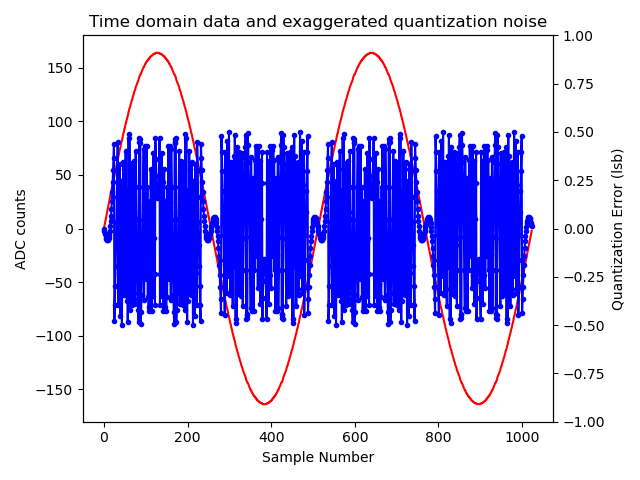

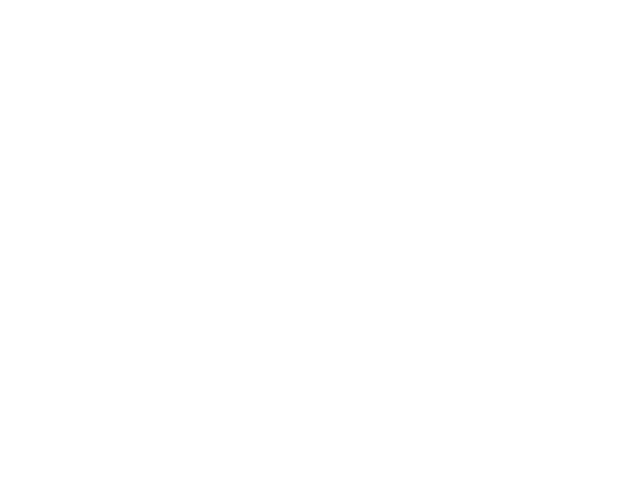

In [4]:
%matplotlib widget

adc_output = my_sig_gen.generate()
my_sig_gen.quantize = False
signal = my_sig_gen.generate()
my_sig_gen.quantize = True

# plt.close('all')
plt.figure(1)
print("Figure Number: ", plt.gcf().number)
fig, ax1 = plt.subplots()

plt.title("Time domain data and exaggerated quantization noise")
plt.xlabel("Sample Number")
plt.ylabel("ADC counts")

ax1.plot(adc_output, color='red')
ax2 = ax1.twinx()
ax2.plot((adc_output - signal), marker='.', color='blue')
ax2.set_ylim(-1.0, 1.0)
ax2.set_ylabel("Quantization Error (lsb)")
fig.tight_layout()
plt.show()


#plt.plot(adc_output)
#plt.plot((adc_output - signal)* 2**(bits-2))
#plt.xlim(0, 100)
#plt.show

## Basics of Signal Analysis using the FFT <a class="anchor" id="fft_basics"></a>
We've built up a signal, quantized it, and gotten a feel for what the error, or noise, looks like in the time domain. But how does quantization noise manifest in the frequency domain, and how do we start picking apart the spectrum and comparing signal to noise?

The next cells go through the process of taking the FFT of the data set, which is the easy part. The harder part is sorting through the FFT output, identifying what is signal and what is noise, and comparing the two. Read through the comments as you run the cells.

In [5]:
# First, let's set up our parameters to accentuate the effects we're looking for, or at least make them easier to locate:
my_sig_gen.N = 4096
my_sig_gen.fs = 100000

my_sig_gen.signal_ampl = 2.5
my_sig_gen.vref = 5.0
my_sig_gen.t_noise = 0.0
my_sig_gen.bits = 16

bin_number = 102

my_sig_gen.freq = my_sig_gen.fs * bin_number / my_sig_gen.N

my_sig_gen.phase = np.random.random()* 2.0 * np.pi # Add random phase. Makes thigns a little more interesting.

adc_output = my_sig_gen.generate()


print("length: ", len(adc_output))
print("max value: ", np.max(adc_output))
print("min value: ", np.min(adc_output))
print("DC content: ", np.average(adc_output))

# Here is the line that does the work of calculating the spectrum from the time domain samples.
# We're dividing by N because the FFT normalization defaults to "backward" - see NumPy docs for details
freq_domain = np.fft.fft(adc_output)/my_sig_gen.N
freq_domain_magnitude = np.abs(freq_domain)

freq_domain_signal = np.zeros(my_sig_gen.N)
freq_domain_noise = np.zeros(my_sig_gen.N)

#Now notch the signal out of the spectrum. We have the advantage here
#that there's only a single bin of signal, and no distortion.

np.copyto(freq_domain_noise, freq_domain_magnitude) #Make a copy
freq_domain_noise[bin_number] = 0 #Zero out positive signal bin
freq_domain_noise[my_sig_gen.N - bin_number] = 0 # And the negative bin
# Note that we're also zeroing out one bin worth of noise. We're going to assume this is insignificant
# in this simulation, but if you're zeroing out lots of bins with a mask, you might want to fill them in
# with the average noise floor from the bins that aren't zeroed
# (or some more intelligent estimate if the noise floor is wiggling around.)

#Make another array that just has the signal
freq_domain_signal[bin_number] = freq_domain_magnitude[bin_number]
freq_domain_signal[my_sig_gen.N - bin_number] = freq_domain_magnitude[my_sig_gen.N - bin_number]

signal = 0.0 #Start with zero signal, zero noise
noise = 0.0

# Sum the power root-sum-square in each bin. Abs() function finds the power, a resistor dissipating
# power does not care what the phase is!

signal_ss = np.sum(((freq_domain_signal)) ** 2)
noise_ss = np.sum(((freq_domain_noise)) ** 2 )

signal = np.sqrt(signal_ss)#  / N
noise = np.sqrt(noise_ss) # / N

snr_fraction = signal / noise
snr = 20*np.log10(signal / noise)
print ("Signal: " + str(signal))
print ("Noise: " + str(noise))
print ("Fractional signal to noise: " + str(snr_fraction))
print ("SNR: " + str(snr) + "dB")
print ("Theoretical SNR based on 6.02*bits + 1.76: ", (6.02 * my_sig_gen.bits) + 1.76)

max_freq_domain_magnitude = max(freq_domain_magnitude)
min_mag = np.ones(my_sig_gen.N)* 1e-14
freq_domain_magnitude_db = 20 * np.log10(np.maximum(freq_domain_magnitude, min_mag) / max_freq_domain_magnitude)

length:  4096
max value:  32768.0
min value:  -32768.0
DC content:  0.0
Signal: 23170.494477785578
Noise: 0.2891693934486467
Fractional signal to noise: 80127.7555741749
SNR: 98.07565956132207dB
Theoretical SNR based on 6.02*bits + 1.76:  98.08


<function matplotlib.pyplot.show(close=None, block=None)>

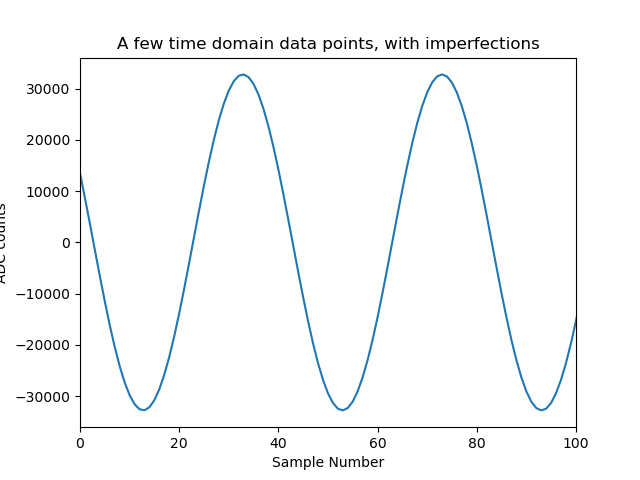

In [6]:
""" Plot time domain data """
# plt.close('all')
plt.figure(plt.gcf().number + 1)
plt.title("A few time domain data points, with imperfections")
plt.xlabel("Sample Number")
plt.ylabel("ADC counts")
plt.plot(adc_output)
plt.xlim(0, 100)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

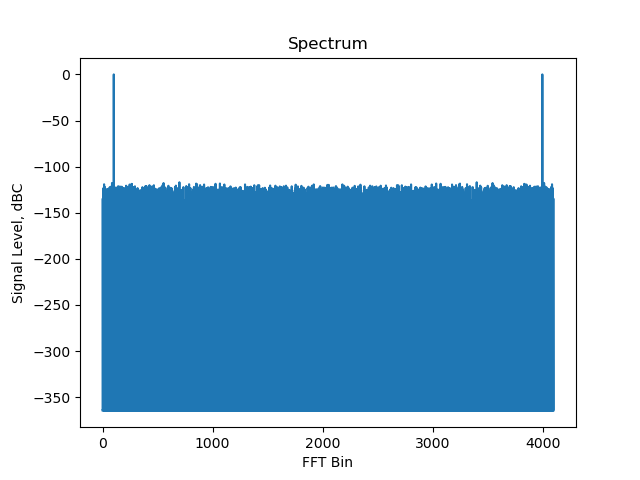

In [7]:
""" Plot frequency domain data """

plt.figure(plt.gcf().number + 1)
plt.title("Spectrum")
plt.xlabel("FFT Bin")
plt.ylabel("Signal Level, dBC")
plt.plot(freq_domain_magnitude_db)
# plt.xlim(0, 500) # Uncomment to manually zoom
#plt.ylim(-140, 0)
plt.show

Alrighty, that was a nice warmup! we've compared a single bin worth of signal to the rest of bins as noise, and plotted out the FFT. But why is the FFT output "mirrored"? Remember that the output of an FFT has the same number of points as the input data, and bin 1 represents a frequency of fs/N. Visually, this is a sinewave that covers a single cycle over the entire time record. And from Nyquist, the FFT output can only digitize to fs/2, which is the center of the FFT. The right-hand side of the FFT is thus a mirroring of the left side, from fs/2 back to DC. Sort of. It's more accurate to think of it as INCREASING in frequency from fs/t UP to fs! Remember that a signal at fs... will ALIAS to DC!

Another important concept - both the input and output of an FFT are complex. It just happens that if you only stuff real values into the FFT input, the outputs will be complex conjugates mirrored around fs/2. That's a mouthful, so let's take a look at a couple of examples from the data above:

In [8]:
# Start with the test signal's bin number.
# Pick a bin, any bin (from 1 to N/2)
test_bin = bin_number
print(freq_domain[test_bin])
print(freq_domain[my_sig_gen.N-test_bin])
print("Check it out... real parts should be equal, imaginary equal and opposite sign...")
print("Let's examine the amplitude - taking the absolute value of the bin, then multiplying by two:")
amplitude = np.abs(freq_domain[test_bin]) * 2.0
print("Amplitude: ", amplitude)

(6736.739679523944+14934.93373480022j)
(6736.739679523943-14934.93373480022j)
Check it out... real parts should be equal, imaginary equal and opposite sign...
Let's examine the amplitude - taking the absolute value of the bin, then multiplying by two:
Amplitude:  32768.02753737527


## Trip down a rabbit hole?
Something to dig into - if you look REALLY closely at the frequency domain plot, you'll notice that if the fundamental frequency is in an even bin, all of the odd bins are ZERO! (Well, -360dB is really really close to zero.) Furthermore, if the fundamental is in an odd bin, all even bins are zero!

What? Seriously? I thought quantization noise was supposed to be spread out more or less randomly? Think about what this means - A signal that is symmetrical, like a square wave, only contains ODD harmonics. Asymmetrical signals, like a sinewave with only positive peaks "chopped off" will contain even harmonics. Does this mean that quantization noise is purely symmetrical or purely asymmetrical, depending on fundamental bin? Something to dig into at some point. But not today.

# Packaging up the FFT analysis
With that out of the way, let's button up our method of plotting FFTs - when we're working with only real samples (vs. complex, as in an I/Q radio signal), we can simply look at bins 0 to N/2-1, and double each bin. Any real valued signal that exceeds fs/2 will simply alias back into the range of DC to fs/2.

In [9]:
""" Button up a few utility functions. """

import numpy as np

%matplotlib widget

def plot_time_and_freq(t, f):
    """Basic plotting routine for time and frequency"""
    from matplotlib import pyplot as plt
    # plt.close('all')
    plt.figure(plt.gcf().number + 1)
    plt.title("Time domain data, with imperfections")
    plt.xlabel("Sample Number")
    plt.ylabel("ADC counts")
    plt.plot(t)
    #plt.xlim(0, 100)
    plt.show

    plt.figure(plt.gcf().number + 1)
    plt.title("Spectrum")
    plt.xlabel("FFT Bin")
    plt.ylabel("Signal Level, dBC")
    plt.plot(f)
    # plt.xlim(0, 100) # Uncomment to manually zoom
    plt.show

def calculate_spectrum_dbc(data, ref = None, dBc = True):
    """ Calculate spectrum in dB releative to the carrier. """
    freq_domain = np.fft.fft(data) / len(data)
    freq_domain_magnitude = (2.0*np.abs(freq_domain)/len(data))[:len(data)//2]
    freq_domain_magnitude = np.maximum(1e-15*np.ones(len(data)//2), freq_domain_magnitude)
    
    max_freq_domain_magnitude = np.max(freq_domain_magnitude)
    if ref is None:
        ref = max_freq_domain_magnitude
    freq_domain_magnitude_db = 20 * np.log10(freq_domain_magnitude / ref)
    return freq_domain_magnitude_db



# Windowing <a class="anchor" id="windowing"></a>
Although it might not have seemed significant at first glance, the biggest simplification in the introductory example is that we parked the fundamental signal at an exact FFT bin. In fact - we DEFINED the signal frequency in terms of FFT bin, then calculated what its actual frequency was based on the sample rate and number of data points.

In reality - this situation is surprisingly difficult to achieve in real life: it requires two signal sources - one to set the sample rate (often called the "clock") and another to generate the analog input signal. They both must be stable, and at least one of them must have very fine frequency resolution (we'll define HOW fine shortly...). Furthermore, they either both need to be extraordinarily accurate (like, rubidium frequency standard accurate), OR more realistically (and lower cost), both sharing the same frequemcy reference. Often benchtop synthesizers will have a 10MHz reference input, output, or both, as BNC jacks on the back panel.

What happens if you're not on an exact frequency bin? Well, you end up with a partial cycyle of the fundamental signal in the data record, and the fundamental "leaks" all over the spectrum. Let's get a picture of how bad it can get:

https://www.gaussianwaves.com/2020/09/window-function-figure-of-merits/

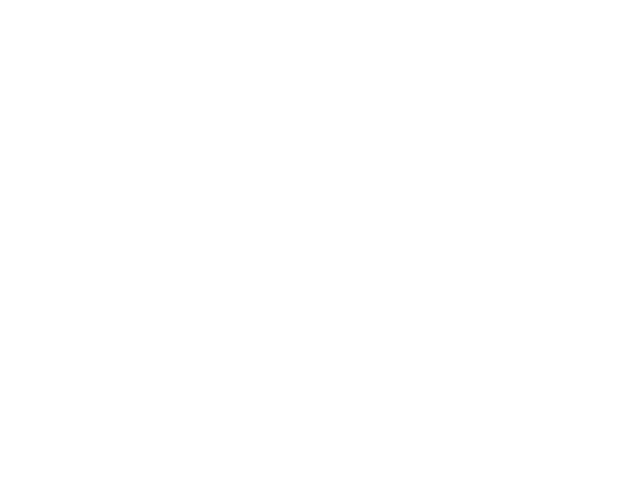

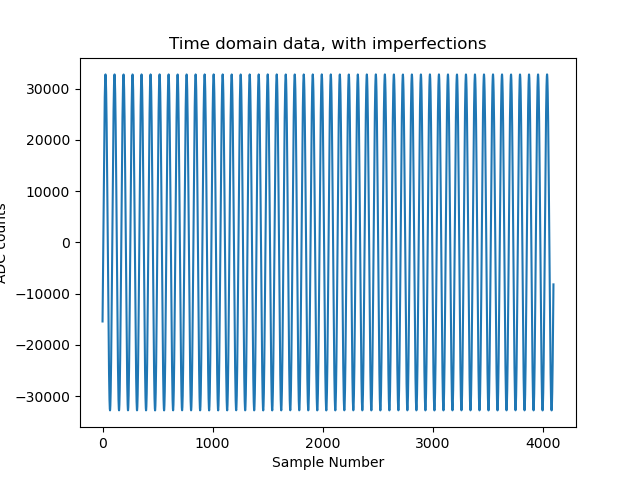

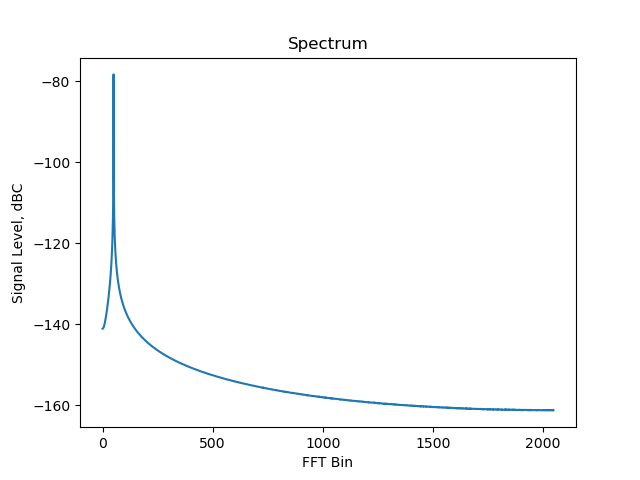

In [10]:
""" Do some experimentation here - let's leave the bin number at 50.0050,
    which is a 100ppm departure from exactly bin 50. Try 1ppm departures, 1000ppm, etc.
    to get a feel for just how perfect you need to be to get an accurate measurement
    of the fundamental with no leakage.
    
    Also note that the phase is randomized so you should be able to run this cell
    over and over again, and see how the leakage "dances" around :)
    """

my_sig_gen.N = 4096
my_sig_gen.fs = 100000
my_sig_gen.phase = np.random.random()* 2.0 * np.pi
my_sig_gen.signal_ampl = 2.5
my_sig_gen.vref = 5.0
my_sig_gen.bits = 16
my_sig_gen.t_noise = 0.0

bin_number = 50.05

my_sig_gen.freq = my_sig_gen.fs * bin_number / my_sig_gen.N

time_domain = my_sig_gen.generate() # sine_sig_gen(N, freq, phase, fs, signal_ampl, vref, bits)
freq_domain_magnitude_db = calculate_spectrum_dbc(time_domain, ref = 2 ** 16)
plot_time_and_freq(time_domain, freq_domain_magnitude_db)

So how do we mitigate this effect? the answer is "windowing". This means multiplying the time domain data by a function that "pinches off" at the ends. The seminal paper on this method is "On the Use of Windows for Harmonic Analysis With the Discrete Fourier Transform" by Frederic Harris. Observe the characteristics of the fundamental after running the following cell. Note that while the noise floor looks much "flatter", the fundamental is spread into several bins. This represents the fundamental tradeoff with choosing different window functions: main lobe width vs. sidelobe suprression.


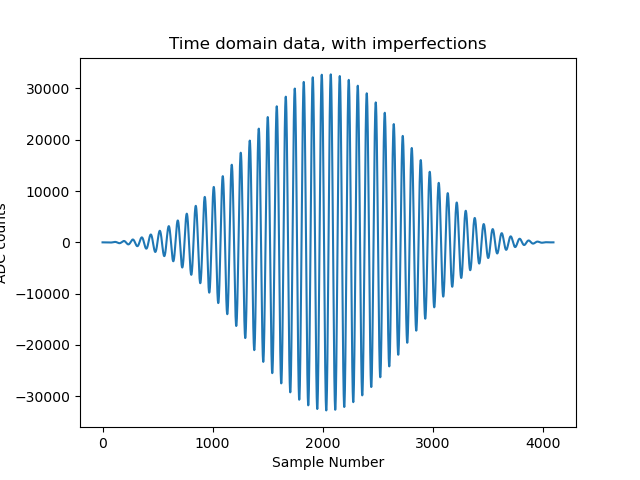

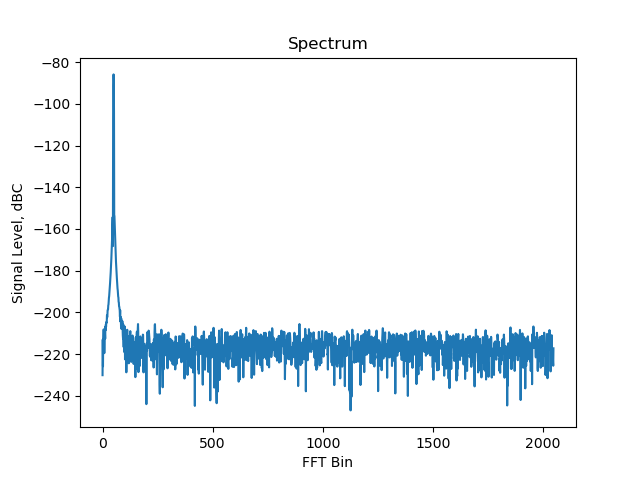

In [11]:
""" Apply windowing """

my_sig_gen.quantize = True
my_sig_gen.N = 4096
my_sig_gen.fs = 100000
my_sig_gen.phase = np.random.random()* 2.0 * np.pi
my_sig_gen.signal_ampl = 2.5
my_sig_gen.vref = 5.0
my_sig_gen.bits = 16

bin_number = 50.1

my_sig_gen.freq = my_sig_gen.fs * bin_number / my_sig_gen.N

time_domain = my_sig_gen.generate() # sine_sig_gen(N, freq, phase, fs, signal_ampl, vref, bits)

window = np.blackman(len(time_domain))

windowed_time_domain = time_domain * window

freq_domain_magnitude_db = calculate_spectrum_dbc(windowed_time_domain, ref = 2 ** 16)

plot_time_and_freq(windowed_time_domain, freq_domain_magnitude_db)

# Deeper Analysis: Pscope <a class="anchor" id="pscope"></a>
Before digging into how to calculate SNR, THD, etc. let's look at a couple of "pre-canned" tools. PScope is Analog Device's ADC testing tool, which while it only talks to proprietary hardware, does give you the ability to load data and analyze it. The file format is somewhat proprietary, so the "save_for_pscope" library takes care of formatting. Another library, sin_params, is a Python implementation of many of PScope's analysis functions. After running the following cell, open Pscope, then file -> Load Data, and open time_domain.adc.

Notice that Pscope does not apply a window by default - select Blackman-Harris 92dB, then compare parameters.

**Note** - looks like there may be a bug, SNR from sin_params looks like it might actually be THD.

Screenshot:

<img src="pscope_vs_sin_params.PNG" width=800>

In [12]:
from save_for_pscope import save_for_pscope
from sin_params import *


my_sig_gen.quantize = True
my_sig_gen.N = 4096
my_sig_gen.fs = 100000
my_sig_gen.phase = np.random.random()* 2.0 * np.pi
my_sig_gen.signal_ampl = 2.5
my_sig_gen.vref = 5.0
my_sig_gen.bits = 16

bin_number = 50.1

my_sig_gen.freq = my_sig_gen.fs * bin_number / my_sig_gen.N

time_domain = my_sig_gen.generate()

# Saving time_domaine twice - workaround because save_for_pscope expects two channels
save_for_pscope("time_domain.adc", 16, True, len(time_domain), "DC0000", "LTC1111", time_domain, time_domain, )

harmonics, snr, thd, sinad, enob, sfdr, floor = sin_params(time_domain)
print("A.C. Performance parameters (ONLY valid for a sine input):")
print("Harmonics:", harmonics)
print("snr: ", thd)
print("Sinad: ", sinad)
print("ENOB: ", enob)
print("SFDR: ", sfdr)
print("Noise Floor: ", floor)


A.C. Performance parameters (ONLY valid for a sine input):
Harmonics: {1: (1073742405.8220775, 50), 2: (0.0002156149500209865, 101), 3: (0.0005602518224872737, 149), 4: (-0.00024309980636712464, 202), 5: (-0.00038293437998639763, 247), 6: (8.049897944132885e-06, 298), 7: (-0.0004186372600904994, 349), 8: (3.7689935479991036e-06, 402), 9: (-8.771041955602248e-05, 451)}
snr:  -128.55293829613697
Sinad:  97.73877823258945
ENOB:  15.943318643287284
SFDR:  122.82516827287814
Noise Floor:  -130.85567979449252


# Deeper Analysis: Genalyzer <a class="anchor" id="genalyzer"></a>
While we're going to be picking away at things piece by piece, you might start to think "is it really this complicated? Hasn't this been done before?" Well, yes. Various tools by Analog Devices and other companies all run through these calculations, each implemented in its own way. Genalyzer is a library of DSP functions for RF measurements, and is intended to adhere to IEEE 1241-2010. A single, cross-platform C++ library with multiple language bindings is provided, allowing consistent analyses to be performed, regardless of language or operating system.

On Windows, run the installer from: https://github.com/analogdevicesinc/genalyzer/actions/runs/2739771918

Then install the Python library:

pip install --index-url https://test.pypi.org/simple/ pylibgenalyzer

**It is NOT your imagination - the syntax of the following cell is a bit obtuse. This has to do with the Genalyzer API, and the fact that it's compatible with multiple languages. Also - the API and documentation are still under development, so stay tuned.**



In [13]:
my_sig_gen = sine_sig_gen()




# def main():
import genalyzer_advanced as gn
#print("Library path: {}".format(gn._genalyzer._libpath))
#print("Version: {}\n".format(gn.__version__))

#
# Setup
#
plot        = True
navg        = 2
nfft        = 1024 * 256
fs          = 1e9
fsr         = 2.0
ampl_dbfs   = -1.0
freq        = 10e6
phase       = 0.110
td          = 0.0
tj          = 0.0
poco        = [0.0, 1.0, 0.0, 0.003]        # distortion polynomial coefficients
qres        = 16                            # quantizer resolution
qnoise_dbfs = -140.0                         # quantizer noise
code_fmt    = gn.CodeFormat.TWOS_COMPLEMENT
sig_type    = gn.DnlSignal.TONE
inl_fit     = gn.InlLineFit.BEST_FIT
rfft_scale  = gn.RfftScale.DBFS_SIN
window      = gn.Window.NO_WINDOW

########################################################################

npts = navg * nfft
ampl = (fsr / 2) * 10**(ampl_dbfs / 20)
qnoise = 10**(qnoise_dbfs / 20)
ssb_fund = 4
ssb_rest = 3
if gn.Window.NO_WINDOW == window:
    freq = gn.coherent(nfft, fs, freq)
    ssb_fund = 0
    ssb_rest = 0

#
# Signal generation and processing
#


########################################################################

my_sig_gen.N = npts
my_sig_gen.fs = fs

# bin_number = 31
# my_sig_gen.freq = my_sig_gen.fs * bin_number / my_sig_gen.N

my_sig_gen.freq = freq

my_sig_gen.signal_ampl = ampl
my_sig_gen.vref = fsr
my_sig_gen.bits = qres
my_sig_gen.t_noise = 73e-6


time_domain = my_sig_gen.generate() 


########################################################################

awf = gn.cos(npts, fs, ampl, freq, phase, td, tj)
#awf = gn.polyval(awf, poco)

# Choose one line below:
# Uncomment to use this notebook's signal generator:
qwf = gn.quantize(time_domain/ 2.0**(my_sig_gen.bits-1), fsr, qres, 0.0, code_fmt)

# Uncomment to use Genalyzer's signal generator:
#qwf = gn.quantize(awf, fsr, qres, qnoise, code_fmt)

# Uncomment to print out a few samples, verify they're approx equal.
# print(time_domain[:16])
# print(qwf[:16])


hist = gn.hist(qwf, qres, code_fmt)
dnl = gn.dnl(hist, sig_type)
inl = gn.inl(dnl, inl_fit)
fft_cplx = gn.rfft(qwf, qres, navg, nfft, window, code_fmt, rfft_scale)

#
# Fourier analysis configuration
#
key = 'fa'
gn.mgr_remove(key)
gn.fa_create(key)
gn.fa_analysis_band(key, "fdata*0.0", "fdata*1.0")
gn.fa_fixed_tone(key, 'A', gn.FaCompTag.SIGNAL, freq, ssb_fund)
# gn.fa_max_tone(key, 'A', gn.FaCompTag.SIGNAL, ssb_fund)
gn.fa_hd(key, 3)
gn.fa_ssb(key, gn.FaSsb.DEFAULT, ssb_rest)
gn.fa_ssb(key, gn.FaSsb.DC, -1)
gn.fa_ssb(key, gn.FaSsb.SIGNAL, -1)
gn.fa_ssb(key, gn.FaSsb.WO, -1)
gn.fa_fsample(key, fs)
print(gn.fa_preview(key, False))
# fn = gn.mgr_save(key)

#
# Analysis
#
wf_results   = gn.wf_analysis(qwf)
hist_results = gn.hist_analysis(hist)
dnl_results  = gn.dnl_analysis(dnl)
inl_results  = gn.inl_analysis(inl)
fft_results  = gn.fft_analysis(key, fft_cplx, nfft)

#
# Print results
#
print("\nWaveform Analysis Results:")
for k, v in wf_results.items():
    print("{:10s}{:16.6f}".format(k, v))
print("\nHistogram Analysis Results:")
for k, v in hist_results.items():
    print("{:10s}{:16.6f}".format(k, v))
print("\nDNL Analysis Results:")
for k, v in dnl_results.items():
    print("{:10s}{:16.6f}".format(k, v))
print("\nINL Analysis Results:")
for k, v in inl_results.items():
    print("{:10s}{:16.6f}".format(k, v))
print("\nFourier Analysis Results:")
for k in ['fsnr', 'dc:mag_dbfs', 'A:freq', 'A:ffinal', 'A:mag_dbfs', 'A:phase']:
    print("{:20s}{:20.6f}".format(k, fft_results[k]))



|  Index  |  Key  |  Type       |  Tag     |  Spec                             |
|  0      |  dc   |  DC         |  DC      |  SSB= 0                           |
|  1      |  A    |  FixedTone  |  Signal  |  F= 9.998321533203125e6 , SSB= 0  |
|  2      |  2A   |  FixedTone  |  HD      |  F= 2A , SSB= 0                   |
|  3      |  3A   |  FixedTone  |  HD      |  F= 3A , SSB= 0                   |
|  4      |  wo   |  WOTone     |  Noise   |  SSB= 0                           |


Waveform Analysis Results:
min          -29212.000000
max           29212.000000
mid               0.000000
range         58424.000000
avg               0.002348
rms           20650.710459
rmsac         20650.710459
min_index     47483.000000
max_index    280472.000000

Histogram Analysis Results:
sum          524288.000000
first_nz_index     3557.000000
last_nz_index    61979.000000
nz_range      58423.000000

DNL Analysis Results:
min              -1.000000
max               2.091374
avg               0.0

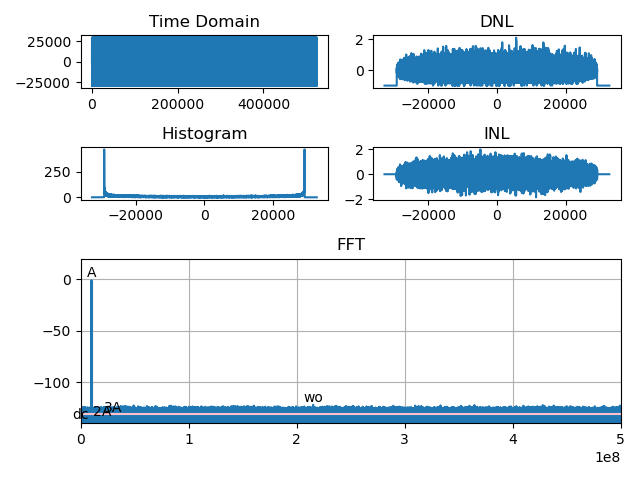

In [14]:
#
# Plot
#
plot = True
if plot:
    import matplotlib.pyplot as pl
    from matplotlib.patches import Rectangle as MPRect
    code_axis = gn.code_axis(qres, code_fmt)
    freq_axis = gn.freq_axis(nfft, gn.FreqAxisType.REAL, fs)
    fft_db = gn.db(fft_cplx)
    fig = pl.figure(plt.gcf().number + 1)
    fig.clf()
    pl.subplot2grid((4, 2), (0, 0))
    pl.title("Time Domain")
    pl.plot(qwf)
    pl.subplot2grid((4, 2), (1, 0))
    pl.title("Histogram")
    pl.plot(code_axis, hist)
    pl.subplot2grid((4, 2), (0, 1))
    pl.title("DNL")
    pl.plot(code_axis, dnl)
    pl.subplot2grid((4, 2), (1, 1))
    pl.title("INL")
    pl.plot(code_axis, inl)
    fftax = pl.subplot2grid((4, 2), (2, 0), rowspan=2, colspan=2)
    pl.title("FFT")
    pl.plot(freq_axis, fft_db)
    pl.grid(True)
    pl.xlim(freq_axis[0], freq_axis[-1])
    pl.ylim(-140.0, 20.0)
    annots = gn.fa_annotations(fft_results)
    for x, y, label in annots["labels"]:
        pl.annotate(label, xy=(x, y), ha='center', va='bottom')
    for line in annots["lines"]:
        pl.axline((line[0], line[1]), (line[2], line[3]), c='pink')
    for box in annots["ab_boxes"]:
        fftax.add_patch(MPRect((box[0], box[1]), box[2], box[3],
            ec='lightgray', fc='gainsboro', fill=True, hatch='x'))
    for box in annots["tone_boxes"]:
        fftax.add_patch(MPRect((box[0], box[1]), box[2], box[3],
            ec='pink', fc='pink', fill=True, hatch='x'))

    pl.tight_layout()
    pl.show()

# Thermal Noise <a class="anchor" id="thermal_noise"></a>
So far, the only imperfections we've introduced are quantization noise (which is actually a property of the signa chain) and non-coherent effects (which are mathematical artifacts.) Now we're going to add in thermal noise, which will ALWAYS exist in any signal. In fact, let's start with a useful simplification and assume that our signal chain is absolutely perfect, and the ADC's sampling circuit is the ONLY source of noise. Many ADC architectures have a sample and hold circuit that captures a sample on a small capacitor with a network of switches as shown below:

**To Do: Add LTspice pic**

The very act of capturing a sample on a capacitor, even a perfect one, introduces noise. If you repeatedly capture a noiseless signal on a capacitor of size C, then the resulting samples will NOT be perfect; they will have a distribution of voltages with a standard deviation of:

SQRT(K*T/C)

Where:

K = Boltzmann's constant (1.380649 × 10-23 J/K)
T = absolute temperature in Kelvin
C = capacitance in farads.

Similar to an ADC's "number of bits", the sample capacitor (along with the full-scale input range) represents an UPPER LIMIT on an ADC's Signal to Noise ratio. Let's look at a real example, the LTC2202. This is a "16-bit" ADC, with a 2.5Vp-p input range, and two 9.1pF sample capacitors. (See datasheet Figure 2.) This gives a thermal noise of:

SQRT(1.380649 × 10^-23 * 300 * 9.1 x 10^-12) * SQRT(2) = 30.31 uVRMS thermal noise.

Where the extra SQRT(2) is due to the fact that the two inputs are independently sampled on two 9.1pF capacitors.

The input range is 2.5Vp-p, or 0.8839 VRMS. The theoretical maximum SNR is then:

20 * log(0.8839 / 30.31 * 10^-6) = 89 dB.

This is 9 dB lower than the theoretical 98.08 dB SNR for a 16-bit converter. Does this mean that we can just not bother reading out one of the bits? Well, if you were ONLY measuring SNR, then yes. But look at this part's integral nonlinearity and distorition - 1.2 lsb and 100 dB under some conditions, respectively. So while the thermal noise dominates the quantization noise, those bits are still required in order to get full linearity performance. A somewhat simplistic way of looking at it is that linearity and distortion require many codes across the ADC's input range to express, so noise will tend to average out. (A subject for another section.)

Let's run the LTC2202 thermal noise and quantization noise through Genalyzer and see what we get out...


**ToDo: Bump up thermal noise such that quantization noise is no longer dominant. Button up SNR analysis, plot out SNR vs. thermal noise.**

In [15]:
my_sig_gen = sine_sig_gen()




# def main():
import genalyzer_advanced as gn
#print("Library path: {}".format(gn._genalyzer._libpath))
#print("Version: {}\n".format(gn.__version__))

#
# Setup
#
plot        = True
navg        = 2
nfft        = 1024 * 256
fs          = 1e9
fsr         = 2.5
ampl_dbfs   = -1.0
freq        = 10e6
phase       = 0.110
td          = 0.0
tj          = 0.0
poco        = [0.0, 1.0, 0.0, 0.003]        # distortion polynomial coefficients
qres        = 16                            # quantizer resolution
qnoise_dbfs = -180.0                         # quantizer noise
code_fmt    = gn.CodeFormat.TWOS_COMPLEMENT
sig_type    = gn.DnlSignal.TONE
inl_fit     = gn.InlLineFit.BEST_FIT
rfft_scale  = gn.RfftScale.DBFS_SIN
window      = gn.Window.NO_WINDOW

########################################################################

npts = navg * nfft
ampl = (fsr / 2) * 10**(ampl_dbfs / 20)
qnoise = 10**(qnoise_dbfs / 20)
ssb_fund = 4
ssb_rest = 3
if gn.Window.NO_WINDOW == window:
    freq = gn.coherent(nfft, fs, freq)
    ssb_fund = 0
    ssb_rest = 0

#
# Signal generation and processing
#


########################################################################

my_sig_gen.N = npts
my_sig_gen.fs = fs

# bin_number = 31
# my_sig_gen.freq = my_sig_gen.fs * bin_number / my_sig_gen.N

my_sig_gen.freq = freq

my_sig_gen.signal_ampl = ampl
my_sig_gen.vref = fsr
my_sig_gen.bits = qres
my_sig_gen.t_noise = 30.31e-6


time_domain = my_sig_gen.generate() 


########################################################################

awf = gn.cos(npts, fs, ampl, freq, phase, td, tj)
#awf = gn.polyval(awf, poco)

# Choose one line below:
# Uncomment to use this notebook's signal generator:
qwf = gn.quantize(time_domain/ 2.0**(my_sig_gen.bits-1), fsr, qres, 0.0, code_fmt)

# Uncomment to use Genalyzer's signal generator:
#qwf = gn.quantize(awf, fsr, qres, qnoise, code_fmt)

# Uncomment to print out a few samples, verify they're approx equal.
# print(time_domain[:16])
# print(qwf[:16])


hist = gn.hist(qwf, qres, code_fmt)
dnl = gn.dnl(hist, sig_type)
inl = gn.inl(dnl, inl_fit)
fft_cplx = gn.rfft(qwf, qres, navg, nfft, window, code_fmt, rfft_scale)

#
# Fourier analysis configuration
#
key = 'fa'
gn.mgr_remove(key)
gn.fa_create(key)
gn.fa_analysis_band(key, "fdata*0.0", "fdata*1.0")
gn.fa_fixed_tone(key, 'A', gn.FaCompTag.SIGNAL, freq, ssb_fund)
# gn.fa_max_tone(key, 'A', gn.FaCompTag.SIGNAL, ssb_fund)
gn.fa_hd(key, 3)
gn.fa_ssb(key, gn.FaSsb.DEFAULT, ssb_rest)
gn.fa_ssb(key, gn.FaSsb.DC, -1)
gn.fa_ssb(key, gn.FaSsb.SIGNAL, -1)
gn.fa_ssb(key, gn.FaSsb.WO, -1)
gn.fa_fsample(key, fs)
print(gn.fa_preview(key, False))
# fn = gn.mgr_save(key)

#
# Analysis
#
wf_results   = gn.wf_analysis(qwf)
hist_results = gn.hist_analysis(hist)
dnl_results  = gn.dnl_analysis(dnl)
inl_results  = gn.inl_analysis(inl)
fft_results  = gn.fft_analysis(key, fft_cplx, nfft)

#
# Print results
#

print("\nFourier Analysis Results:")
for k in ['fsnr', 'dc:mag_dbfs', 'A:freq', 'A:ffinal', 'A:mag_dbfs', 'A:phase']:
    print("{:20s}{:20.6f}".format(k, fft_results[k]))



|  Index  |  Key  |  Type       |  Tag     |  Spec                             |
|  0      |  dc   |  DC         |  DC      |  SSB= 0                           |
|  1      |  A    |  FixedTone  |  Signal  |  F= 9.998321533203125e6 , SSB= 0  |
|  2      |  2A   |  FixedTone  |  HD      |  F= 2A , SSB= 0                   |
|  3      |  3A   |  FixedTone  |  HD      |  F= 3A , SSB= 0                   |
|  4      |  wo   |  WOTone     |  Noise   |  SSB= 0                           |


Fourier Analysis Results:
fsnr                           90.000695
dc:mag_dbfs                   -95.254772
A:freq                    9998321.533203
A:ffinal                  9998321.533203
A:mag_dbfs                     -2.938200
A:phase                        -1.570796


What do you observe? One example run with 30 uV noise gave an SNR of about 90dB, about 0.7dB too good, but close.

**ToDo:** Dig into the discrepancy.

# Jitter and Phase Noise <a class="anchor" id="phase_noise"></a>

**To Do: Verify jitter and analog input frequency vs. maximum SNR**



## Signal Generator Test: Synthesizing a Square Wave

This is the classic harmonic experiment. Start with a sinewave, then add in odd harmonics with amplitudes of 1/(harmonic number). Peek at the code, it should be self explanatory.

harmonics:  [[0.0, 0.0], [0.3333333333333333, 0.0], [0.0, 0.0], [0.2, 0.0], [0.0, 0.0], [0.14285714285714285, 0.0], [0.0, 0.0], [0.1111111111111111, 0.0], [0.0, 0.0], [0.09090909090909091, 0.0], [0.0, 0.0], [0.07692307692307693, 0.0]]
quantize?  True


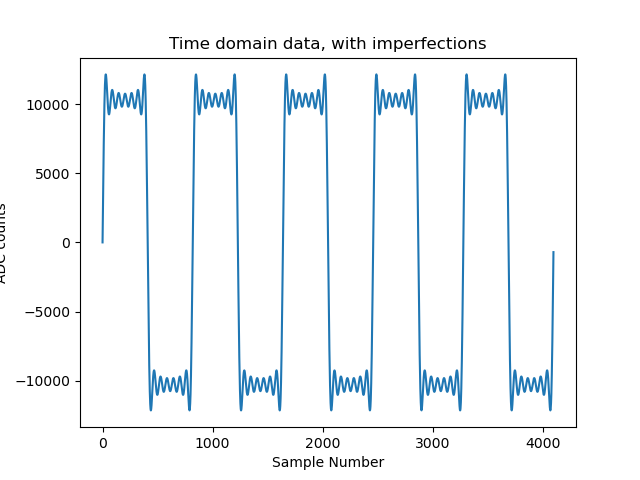

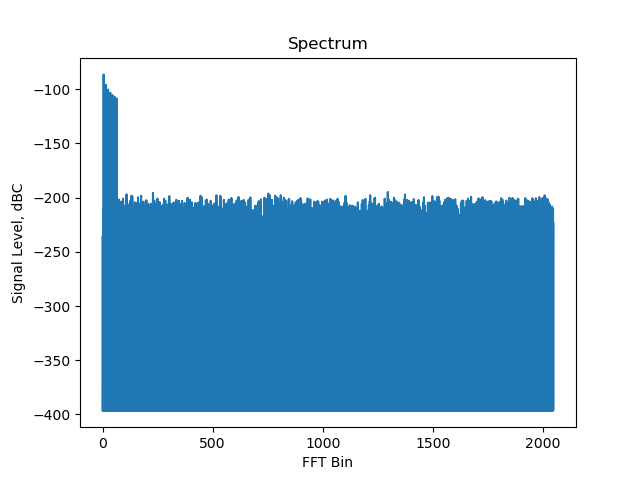

In [16]:
my_sig_gen = sine_sig_gen()

my_sig_gen.harmonics = [[0.0, 0.0],      # Second Harmonic (absent)
                        [(1.0/3.0), 0.0],# 3rd harmonic, amplitude 1/3
                        [0.0, 0.0],      # 4th Harmonic (absent)
                        [(1.0/5.0), 0.0],# 5th harmonic, amplitude 1/5
                        [0.0, 0.0],      # 6th Harmonic (absent)
                        [(1.0/7.0), 0.0],# 7th harmonic, amplitude 1/7
                        [0.0, 0.0],      # 8th Harmonic (absent)
                        [(1.0/9.0), 0.0],# 9th harmonic, amplitude 1/9
                        [0.0, 0.0],      # 10th Harmonic (absent)
                        [(1.0/11.0), 0.0],# 11th harmonic, amplitude 1/11
                        [0.0, 0.0],      # 12th Harmonic (absent)
                        [(1.0/13.0), 0.0]]# 13th harmonic, amplitude 1/13

print("harmonics: ", my_sig_gen.harmonics)
print("quantize? ", my_sig_gen.quantize)

time_domain = my_sig_gen.generate()

freq_domain_magnitude_db = calculate_spectrum_dbc(time_domain, ref = 2 ** 16)
plot_time_and_freq(time_domain, freq_domain_magnitude_db)

# Talking to Hardware (Warmup) <a class="anchor" id="hardware"></a>

**To Cover Next:**


*   Different types of windows and their figures of merit
*   Interpreting windowed FFT data - how to sum power across a few bins, etc.
*   SNR/THD calculations, locating harmonics, figuring out what to count as signal, noise, and harmonics.
*   Masking out regions of the noise floor that we know can't be blamed on the ADC (automasking in Pscope)
*   Video (scalar) averaging to smooth out the noise floor
*   Vector averaging to reduce noise floor while accurately measuring harmonically related components



# Talking to Hardware (Warmup) <a class="anchor" id="hardware"></a>

In [ ]:
# Okay now let's talk to some hardware!

# Here's how to connect to a local runtime:
# https://research.google.com/colaboratory/local-runtimes.html
# And after doing so, this actually works!!:
# For reference:
# pip install --upgrade jupyter_http_over_ws>=0.0.7 && jupyter serverextension enable --py jupyter_http_over_ws

# jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com'  --port=8888  --NotebookApp.port_retries=0


# It looks like installing from pip works fine, but...
# shouldn't need to do here if the Jupyter environment is set up properly.
# !pip install pyadi-iio

import adi
print("ADI path:")
print(adi.__file__)
print("ADI objects:")
print(dir(adi))



In [ ]:
# Warmup for seeing if we can talk to hardware here...
# Note that you need to have a Pi with an LM75 attached somewhere on your network
my_uri = "ip:experimenter.local" # "experimenter" is Thoren's "always-on" hacker board
my_temp_sensr = adi.lm75(uri=my_uri)

print("\nChecking temperature channel...")
print("Temperature raw: " + str(my_temp_sensr.input))
print(
    "Temperature in deg. Celsius: " + str(my_temp_sensr.to_degrees(my_temp_sensr.input))
)

print("\nUpdate interval: " + str(my_temp_sensr.update_interval))


print("\nMax threshold: " + str(my_temp_sensr.to_degrees(my_temp_sensr.max)))
print("Max hysteresis: " + str(my_temp_sensr.to_degrees(my_temp_sensr.max_hyst)))

print("\nSetting max threshold, hyst. to 30C, 25C...\n")

my_temp_sensr.max = my_temp_sensr.to_millidegrees(30.0)
my_temp_sensr.max_hyst = my_temp_sensr.to_millidegrees(25.0)

print("New thresholds:")
print("Max: " + str(my_temp_sensr.to_degrees(my_temp_sensr.max)))
print("Max hysteresis: " + str(my_temp_sensr.to_degrees(my_temp_sensr.max_hyst)))

del my_temp_sensr

# Talkigng to Hardware (Actual ADC data)

Okay, now that we've successfully talked to a basic sensor, let's grab some data from an actual ADC!

In [ ]:
'''
NOTE: At the moment, the LTC2387 interface is in this branch:
https://github.com/mthoren-adi/pyadi-iio/tree/ltc2387_dev

'''


import numpy as np
from scipy import signal

device_name = "ltc2387"

# Optionally passs URI as command line argument,
# else use default context manager search
my_uri = sys.argv[1] if len(sys.argv) >= 2 else None
print("uri: " + str(my_uri))

my_adc = adi.ltc2387(uri=my_uri)
my_adc.rx_buffer_size = 4096
my_adc.sampling_frequency = 10000000

data = my_adc.rx()

# Figure out how to do this correctly - need to sign extend bit 17
for i in range(len(data)):
    if data[i] > 2 ** 17:
        data[i] -= 2 ** 18

x = np.arange(0, len(data))
plt.figure(1)
plt.clf()
plt.plot(x, data)
plt.show()

f, Pxx_den = signal.periodogram(data, my_adc.sampling_frequency, window="blackman")

plt.figure(2)

plt.clf()
plt.semilogy(f, Pxx_den)
plt.ylim([1e-5, 1e5])
plt.xlabel("frequency [Hz]")
plt.ylabel("PSD [V**2/Hz]")
plt.draw()
plt.pause(0.05)

del my_adc

Next Steps:
1. Run sin_params analysis
2. Pick apart analysis, cover windowing, summing signal, noise, and harmonic power